# Recommender System

We will be developing a movie recommender system based upon Collaborative-filtering to predict the name of the movie based upon the reviews of the other critics having similar taste. The systesm uses two different methods for finding similairties between the critics known as Euclidean-Distance-Score and Pearson-Correlation-Score. The final reault for both the methods were almost similar. After finding the similarity between critics, it uses the weighted average method to assign higher weight to the peer interest critics. Finally, It normalizes the score by deviding it by the similarities of the critics who reviewed that movie.


#### Finding Similar DataPoint

Two ways for calculating similarity scores : 
1. Euclidean Distance Score
2. Pearson Correlation Score

<hr style="height:2px">

In [1]:
# Import Packages

from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Getting more than one output Line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Getting the Dataset

movies= pd.read_csv("./input/movies.csv") # ,nrows=5000)
movies.head()

ratings=pd.read_csv("./input/ratings.csv",usecols=['userId','movieId','rating']) #,nrows=1000)
ratings.head()

tags= pd.read_csv('./input/tags.csv')
tags.head()



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [3]:
# Deleting unnecessary columns
## for time being we will not consider the timestamp of movie for our analysis


del tags['timestamp']

> ## **Descriptive Statistics**

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


**Takeaway** : As we can see MovieIDs are some randomly generated number, so we will not be using this dataframe in our analysis. The only use for this table will be for Lookup of movie titles after the prediction.

In [5]:
ratings['rating'].describe(include='all')

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

rating
0.5     868
1.0    1959
1.5    1204
2.0    3130
2.5    2409
3.0    4771
3.5    3612
4.0    5141
4.5    2454
5.0    3127
Name: movieId, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87422e0320>]], dtype=object)

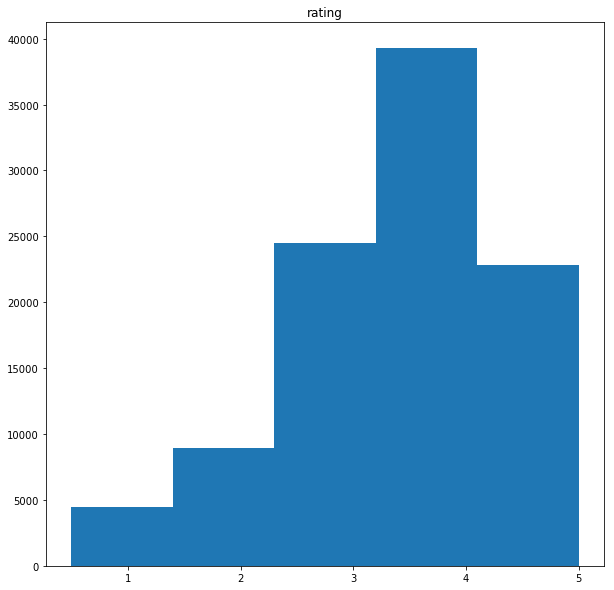

In [6]:
ratings.groupby('rating')['movieId'].nunique()
%matplotlib inline
ratings.hist(column='rating',figsize=(10,10),bins=5,grid=False)

* value of the ratings ranges from 0.5 to 5.0
* User tend to give 4 ratings movie that thay liked. They rarely give 1 star or less to a movie.
* **Future Plan**: (To decrease the complexity of model we can round ratings to their closest integer.)


getdvd       33
Ei muista    29
toplist07    26
tivo         26
toplist12    20
tcm          20
toplist11    20
toplist15    19
toplist08    19
toplist09    18
toplist10    18
toplist14    18
toplist06    16
holes00s     16
funny        16
Name: tag, dtype: int64

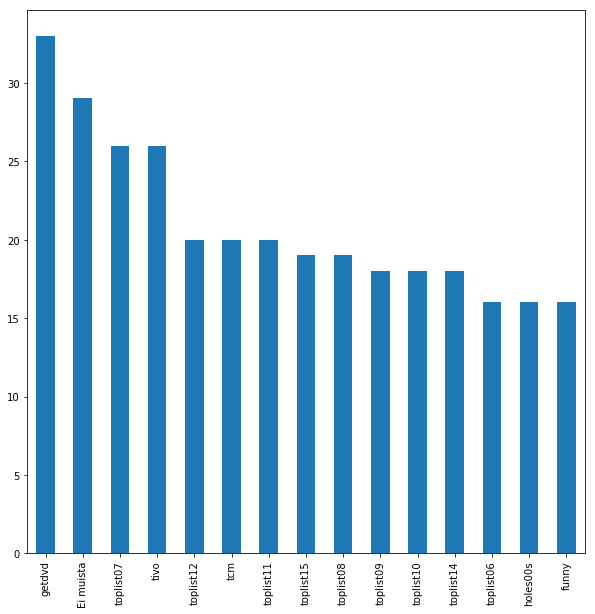

In [7]:
tag_counts = tags['tag'].value_counts()
tag_counts[:15]
tag_counts[:15].plot(kind='bar' , figsize=(10,10))

In [8]:
movies['movieId'].count()


9125

### Analysis of different genres

#### Removing NaN values

In [9]:
genre_filter= (movies['genres'] == '(no genres listed)')
## Removing movies with no genre

movies=movies[~genre_filter]
movies=movies.reset_index(drop=True)  ## God bless StackOverflow.. Remeber removing filtered rows does not reindex the dataframe



#### Checking Total genres present in DataSet

In [10]:
genres_count= {}
for row in range(movies['movieId'].count()):
    for genre in movies['genres'][row].split("|"):
        if(genre != ''):
            genres_count[genre]= genres_count.get(genre,0)+1
        
genres_count


{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'War': 367,
 'Western': 168}

<Container object of 19 artists>

([<matplotlib.axis.YTick at 0x7f873eb21860>,
 <a list of 19 Text yticklabel objects>)

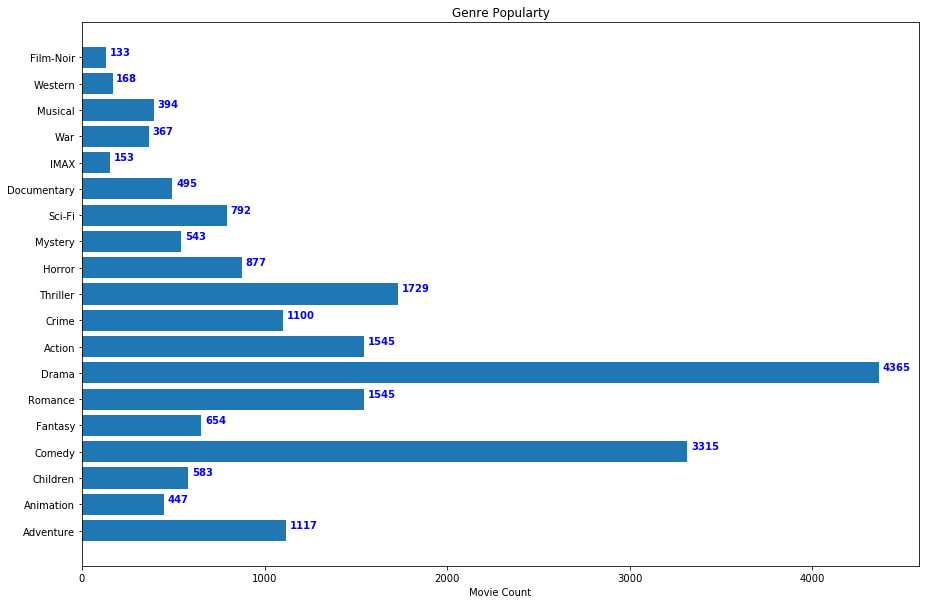

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(range(len(genres_count)),genres_count.values())
plt.yticks(range(len(genres_count)),list(genres_count.keys()))
plt.xlabel('Movie Count')
plt.title("Genre Popularty")
for i, v in enumerate(genres_count.values()):
    ax.text(v + 20, i + .10, v, color='blue', fontweight='bold')

***Deduction*** :
* There are high number of movies from genre Drama & Comedy. So, they might create abias toward the movies which are  from these genres.
* Film- noir & IMAX are the least popular category for films

> ## **Euclidean Distance Score**

euclidean distance is the square root of the sum of squared differences between corresponding elements of the two vectors.Euclidean distance is only appropriate for data measured on the same scale.
* distance = 1/(1+sqrt of sum of squares between two points)
* value varies between 0 to 1, where closeness to 1 implies higher similarity.****

In [14]:
def euclidean_distance(person1,person2):
    #Getting details of person1 and person2
    df_first= ratings.loc[ratings['userId']==person1]
    df_second= ratings.loc[ratings.userId==person2]
    
    #Finding Similar Movies for person1 & person2 
    df= pd.merge(df_first,df_second,how='inner',on='movieId')
    
    #If no similar movie found, return 0 (No Similarity)
    if(len(df)==0): return 0
    
    #sum of squared difference between ratings
    sum_of_squares=sum(pow((df['rating_x']-df['rating_y']),2))
    return 1/(1+sum_of_squares)
    
# Checking working by passing similar ID, Corerelation should be 1
euclidean_distance(1,1) # Swwweeettt!!!

1.0

> ## **Pearson Correlation Score** 

* Correlation between sets of data is a measure of how well they are related. It shows the linear relationship between two sets of data. In simple terms, it answers the question, Can I draw a line graph to represent the data?

* * Value varies between -1 to 1.[ 0-> Not related ; -1 -> perfect negatively corelated ; 1-> perfect positively corelated] 

Slightly better than Euclidean because it addresses the the situation where the data isn't normalised. Like a User is giving high movie ratings in comparison to AVERAGE user.

In [16]:
def pearson_score(person1,person2):
    
    #Get detail for Person1 and Person2
    df_first= ratings.loc[ratings.userId==person1]
    df_second= ratings.loc[ratings.userId==person2]
    
    # Getting mutually rated items    
    df= pd.merge(df_first,df_second,how='inner',on='movieId')
    
    # If no rating in common
    n=len(df)
    if n==0: return 0

    #Adding up all the ratings
    sum1=sum(df['rating_x'])
    sum2=sum(df['rating_y'])
    
    ##Summing up squares of ratings
    sum1_square= sum(pow(df['rating_x'],2))
    sum2_square= sum(pow(df['rating_y'],2))
    
    # sum of products
    product_sum= sum(df['rating_x']*df['rating_y'])
    
    ## Calculating Pearson Score
    numerator= product_sum - (sum1*sum2/n)
    denominator=sqrt((sum1_square- pow(sum1,2)/n) * (sum2_square - pow(sum2,2)/n))
    if denominator==0: return 0
    
    r=numerator/denominator
    
    return r

#Checking function by passing similar ID, Output should be 1
pearson_score(1,1)

1.0

>## **Getting result based on Pearson Score**

In [17]:
# Returns the best matches for person from the prefs dictionary.
# Number of results and similarity function are optional params.
def topMatches(personId,n=5,similarity=pearson_score):
    scores=[(similarity(personId,other),other) for other in ratings.loc[ratings['userId']!=personId]['userId']]
    # Sort the list so the highest scores appear at the top
    scores.sort( )
    scores.reverse( )
    return scores[0:n]

topMatches(1,n=3) ## Getting 3 most similar Users for Example 

KeyboardInterrupt: 

>## **Getting Recommendation**

In [ ]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommnedation(personId, similarity=pearson_score):
    '''
    totals: Dictionary containing sum of product of Movie Ratings by other user multiplied by weight(similarity)
    simSums: Dictionary containung sum of weights for all the users who have rated that particular movie.
    '''
    totals,simSums= {},{}
    
    df_person= ratings.loc[ratings.userId==personId]
    
    for otherId in ratings.loc[ratings['userId']!=personId]['userId']: # all the UserID except personID
        
        # Getting Similarity with OtherID
        sim=similarity(personId,otherId)
        
        # Ignores Score of Zero or Negatie correlation         
        if sim<=0: continue
            
        df_other=ratings.loc[ratings.userId==otherId]
        
        #Movies not seen by the personID
        movie=df_other[~df_other.isin(df_person).all(1)]
        
        for movieid,rating in (np.array(movie[['movieId','rating']])):
            #similarity* Score
            totals.setdefault(movieid,0)
            totals[movieid]+=rating*sim
            
            #Sum of Similarities
            simSums.setdefault(movieid,0)
            simSums[movieid]+=sim
            
        
        
        
        # Creating Normalized List
        ranking=[(t/simSums[item],item) for item,t in totals.items()]
        
        # return the sorted List
        ranking.sort()
        ranking.reverse()
        recommendedId=np.array([x[1] for x in ranking])
        
        
        return np.array(movies[movies['movieId'].isin(recommendedId)]['title'])[:20]

In [ ]:
# Example Recoomendation
#returns 20 recommended movie for the given UserID
# userId can be ranged from 1 to 671
getRecommnedation(1)
getRecommnedation(671)


### ***Future Improvements***
---
* Applying more sophisticated similarities score methods to improve the suggestions.
* Write a function to precompute user similarities, and alter the recommendation code to use only the top five other users to get recommendations.

